In [1]:
!pip install transformers
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.1/7.1 MB 51.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 81.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Libraries

In [2]:
import csv
import requests
import torch
import pandas as pd
import networkx as nx
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
from string import punctuation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Fetching and Saving Twitter Data

In [3]:
url = "https://twitter135.p.rapidapi.com/Search/"

querystring = {"q": "HP India products", "count": "200"}

headers = {
    "X-RapidAPI-Key": "Enter your key",
    "X-RapidAPI-Host": "twitter135.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

if response.status_code == 200:
    data = response.json()
    tweets = data['globalObjects']['tweets']
    with open('HP_Twitter_DATA.csv', 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID', 'Comments'])

        for tweet_id, tweet_data in tweets.items():
            tweet_id = tweet_id.strip('"')
            full_text = tweet_data.get('full_text', '')
            writer.writerow([tweet_id, full_text])

    print('CSV file created successfully.')
else:
    print('Error:', response.status_code)


CSV file created successfully.


# Fetching and Saving Amazon Reviews


In [4]:
asin_list = []
review_list = {
    'review_id':[],
    'review_title':[],
    'review_comment':[]
}

def rid():
    global asin_list
    url = "https://real-time-amazon-data.p.rapidapi.com/search"

    querystring = {"query":"HP Printer","page":"1","country":"IN","category_id":"aps"}

    headers = {
    	"X-RapidAPI-Key": "Enter your key",
    	"X-RapidAPI-Host": "real-time-amazon-data.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    data = response.json()
    product_list = data['data']['products']
    for asin in product_list:
        asin_list.append(asin['asin'])
    print(asin_list)

def comments():
    url = "https://real-time-amazon-data.p.rapidapi.com/product-reviews"
    headers = {
        "X-RapidAPI-Key": "Enter your key",
        "X-RapidAPI-Host": "real-time-amazon-data.p.rapidapi.com"
    }
    for asin in asin_list:
        global review_list
        querystring = {"asin": f"{asin}", "country": "IN", "verified_purchases_only": "false",
                       "images_or_videos_only": "false", "page": "1", "page_size": "100"}
        response = requests.get(url, headers=headers, params=querystring)

        data = response.json()
        # print(data)  # Debug print

        if 'data' in data:
            if 'reviews' in data['data']:
                product_list = data['data']['reviews']
                for ids in product_list:
                    review_list['review_id'].append(ids['review_id'])
                    review_list['review_title'].append(ids['review_title'])
                    review_list['review_comment'].append(ids['review_comment'])
            else:
                print("No reviews found for ASIN:", asin)
        else:
            print("No data found for ASIN:", asin)

    print(review_list)


def out():
    global review_list
    with open('HP_Amazon_DATA.csv', 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID', 'Comments'])

        for i in range(len(review_list['review_id'])):
            review_id = review_list['review_id'][i]
            review_comment = review_list['review_comment'][i]
            writer.writerow([review_id, review_comment])
        print('CSV file created successfully.')


rid()
comments()
out()

['B08D9NDZ1Y', 'B0BN1XT6TF', 'B08D9MNH4B', 'B08CYLT7BK', 'B008HDF4J4', 'B08CYMP63S', 'B08CYRBXYX', 'B08C3J8F4M', 'B0BN287KYS', 'B08D9N3VCX', 'B07T2FJGDV', 'B09MFHQL9J', 'B00LO3NQYY', 'B08D9MZTQ7', 'B09HXR44XS', 'B07RY417JQ']
No reviews found for ASIN: B08D9MNH4B
No data found for ASIN: B08CYMP63S
No data found for ASIN: B08CYRBXYX
No data found for ASIN: B08C3J8F4M
No data found for ASIN: B0BN287KYS
No data found for ASIN: B08D9N3VCX
No data found for ASIN: B07T2FJGDV
No data found for ASIN: B09MFHQL9J
No data found for ASIN: B00LO3NQYY
No data found for ASIN: B08D9MZTQ7
No data found for ASIN: B09HXR44XS
No data found for ASIN: B07RY417JQ
{'review_id': ['R32BKUR1JYFWNN', 'R3E7YWE1ALH6JF', 'R3ISJ8CCMTYJ6J', 'R1A4W90ISK1SSC', 'R38KWTP9XS2O0X', 'R1C2W2X86QGLBP', 'RB75Y0Z2N5RVY', 'R37H79FGVNLI6U', 'R3D35GUVV46MI0', 'R1M7QTLUY0V2WQ', 'RS75FOY13AIG9', 'R9ND7QWH7XQYA', 'R228SX2WEWNRQ0', 'R37LLH8581A04J', 'R3QVZXMSS2TLR', 'RYZ9YNAV20VMU', 'R13BAOX129PB1V', 'R1B02USPU5PXG4', 'REGXAONKJNEME', '

# Preprocessing Twitter and Amazon Data


In [5]:
df1 = pd.read_csv('HP_Amazon_DATA.csv')
df2 = pd.read_csv('HP_Twitter_DATA.csv')

# Concatenate the rows from both files
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged data to a new CSV file
merged_df.to_csv('HP_SM_DATA.csv', index=False)

print('CSV files merged successfully. Merged data saved to HP_SM_DATA.')

CSV files merged successfully. Merged data saved to HP_SM_DATA.


In [6]:
# Read the CSV file into a DataFrame
df = pd.read_csv('HP_SM_DATA.csv')

# Set up stopwords and tokenizer
stopwords_set = set(ENGLISH_STOP_WORDS)
vectorizer = TfidfVectorizer()

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = ''.join([c for c in text if c not in punctuation])
        
        # Remove stopwords
        tokens = [token for token in text.split() if token not in stopwords_set]
        
        # Join tokens back into a string
        preprocessed_text = ' '.join(tokens)
        
        return preprocessed_text
    else:
        return ""

# Apply preprocessing to the 'Comments' column
df['Preprocessed Text'] = df['Comments'].apply(preprocess_text)

# Save the preprocessed data to a new CSV file
df.to_csv('HP_Preprocessed_DATA.csv', index=False)

# Print completion message
print('Preprocessing complete. Preprocessed data saved to HP_Preprocessed_DATA.csv.')

Preprocessing complete. Preprocessed data saved to HP_Preprocessed_DATA.csv.


# Sentiment Analysis of Preprocessed Data


In [10]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Read the preprocessed data from the CSV file
data = pd.read_csv('HP_Preprocessed_DATA.csv')

# Access the 'Preprocessed Text' column from the DataFrame
reviews = data['Preprocessed Text'].astype(str)

# Analyze sentiment for each review and collect the scores

sentiments = []
for text in reviews:
    sentiment_score = sid.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        sentiment = 'Appreciation'
    elif sentiment_score['compound'] <= -0.05:
        sentiment = 'Complaint'
    else:
        sentiment = 'Suggestion'
    sentiments.append(sentiment)
    print(f"Review: {text}")
    print(f"Sentiment: {sentiments}")
    print()
    
data['Sentiment'] = sentiments


Review: buying printer check brand features quality warrenty hp deskjet printer initial cost printer low compare operating cost purchase printer 2499 diwali offer cartridge price high want change approximately 2500 black colors making jugaads try refill cartridges watching youtube videos lead loss printer head leakeage inks printer personally recommend buy inkjet laserjet printer better experience long run initial cost high future operating cost lowcaution hp ink catridges infamous ink level reuction 100 20 just printing 5 color picture glossy paperbefore buying printer consider abovethe ridiculous reduction ink level occurs toink drying catridgeor using used counterfeit catridgesmajor cause ink drying happen buy official hp storealmost 50 hp ink catridges reviews tell thatso means 50 chance recieve catrige print 10 pages 60 pagesit better reviews amazon ink color 805 805xl tri color blackafter printing 5 glossy paper color photo ink level preinstalled catridges reduced 100 20 photo pr

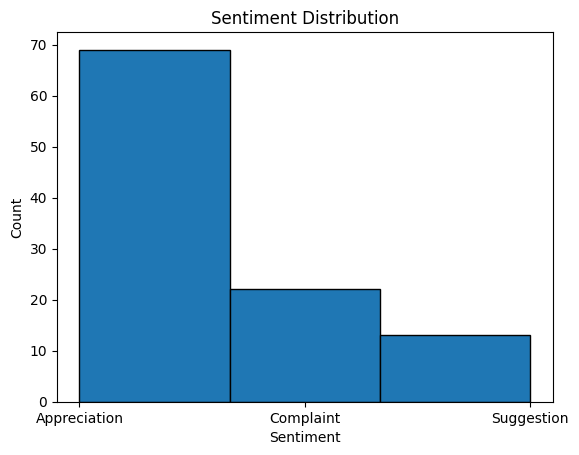

In [11]:
plt.hist(data['Sentiment'], bins=3, edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

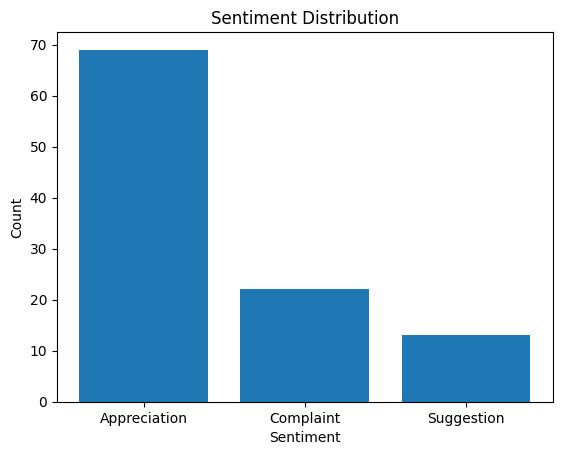

In [12]:
sentiment_counts = data['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

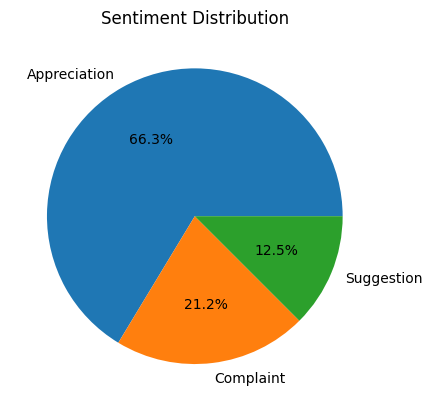

In [13]:
sentiment_counts = data['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

# Sentiment Analysis and Knowledge Graph

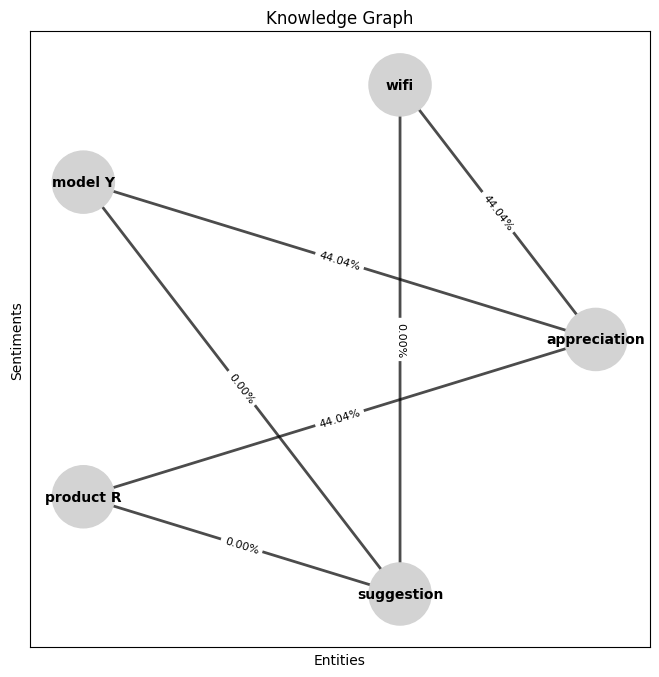

In [17]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# New data
new_data = [
    "model Y has good wifi, bluetooth and usb printing options",
    "model X has easy installation and print setup",
    "black colour got refill after 56 pages of product R",
]

# Preprocess the new data and calculate sentiment scores
sentiments = []
entities_occurrences = {}
sentiment_scores = {}

for text in new_data:
    sentiment_score = sid.polarity_scores(text)
    sentiment = 'appreciation' if sentiment_score['compound'] > 0 else 'complain' if sentiment_score['compound'] < 0 else 'suggestion'
    sentiments.append(sentiment)

    # Extract entities from the text
    tokens = nltk.word_tokenize(text)
    entities = [token.lower() for token in tokens if token.isalnum()]
    
    # Count the occurrence of each entity
    for entity in entities:
        entities_occurrences[entity] = entities_occurrences.get(entity, 0) + 1
    
    # Store sentiment scores
    sentiment_scores[sentiment] = sentiment_score['compound']

# Create a graph
G = nx.DiGraph()  # Use DiGraph for directed edges

# Iterate over each data point and its predicted sentiment
for data, sentiment in zip(new_data, sentiments):
    entities = ['wifi', 'model Y', 'product R']  # Modify as needed based on your data

    # Add the sentiment node if it doesn't exist
    if sentiment not in G:
        G.add_node(sentiment, label='Sentiment')

    # Add the entities as nodes if they don't exist
    for entity in entities:
        if entity not in G:
            G.add_node(entity, label='Entity')

    # Add edges between the sentiment and entities with sentiment score as weight
    for entity in entities:
        weight = sentiment_scores[sentiment]
        G.add_edge(entity, sentiment, weight=weight)

# Set node positions using a circular layout
pos = nx.circular_layout(G)

# Set the figure size
plt.figure(figsize=(8, 8))

# Draw nodes and edges
node_colors = {'Sentiment': 'lightgray', 'Entity': 'lightgray', 'appreciation': 'lightgreen', 'suggestion': 'lightblue', 'complain': 'lightpink'}
nx.draw_networkx_nodes(G, pos, node_color=[node_colors[G.nodes[node]['label']] if 'label' in G.nodes[node] else node_colors[node] for node in G.nodes()], node_size=2000)

# Find the sentiment with the highest score
highest_sentiment = max(sentiment_scores, key=sentiment_scores.get)

# Draw edges with the highest sentiment score as weight
for u, v, data in G.edges(data=True):
    weight = data.get('weight', 0)
    if sentiment_scores[highest_sentiment] == max([data.get('weight', 0) for _, _, data in G.edges(data=True)]):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2.0, alpha=0.7, arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{weight * 100:.2f}%'}, font_size=8)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Set labels and title
plt.xlabel('Entities')
plt.ylabel('Sentiments')
plt.title('Knowledge Graph')

# Show the graph
plt.show()